In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys
module_path = os.path.abspath("/workspace/categorical-dsm/")
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchinfo import summary
from models.score_base import TabScoreModel

import seaborn as sns
import matplotlib as mpl

mpl.rc('figure', figsize=(10, 4), dpi=100)
sns.set_theme()

In [3]:
from configs import bank_config as cfg

config = cfg.get_config()
config

data:
  anomaly_label: 'yes'
  categories:
  - 12
  - 4
  - 8
  - 3
  - 3
  - 3
  - 2
  - 10
  - 5
  - 3
  dataset: bank
  label_column: y
  numerical_features: 0
device: !!python/object/apply:torch.device
- cpu
devtest: false
eval:
  batch_size: 1024
model:
  act: gelu
  dropout: 0.0
  ema_rate: 0.999
  embedding_type: fourier
  estimate_noise: true
  layers: 20
  name: tab-resnet
  ndims: 1024
  num_scales: 20
  sigma_max: 1.0
  sigma_min: 0.1
  tau_max: 20
  tau_min: 2.0
  time_embedding_size: 128
msma:
  checkpoint: best
  denoise: true
optim:
  beta1: 0.9
  beta2: 0.999
  grad_clip: 1.0
  lr: 0.001
  optimizer: AdamW
  scheduler: cosine
  weight_decay: 0.0001
seed: 42
sweep:
  early_terminate:
    eta: 2
    min_iter: 50000
    s: 3
    type: hyperband
  method: bayes
  metric:
    name: val_loss
  parameters:
    model_act:
      values:
      - gelu
      - swish
    model_dropout:
      values:
      - 0.0
      - 0.1
      - 0.2
      - 0.3
      - 0.4
      - 0.5
    model_em

In [17]:
sum(config.data.categories)

53

In [4]:
assert config.data.dataset == "bank"

In [5]:
workdir = f"/workspace/categorical-dsm/results/{config.data.dataset}/"
workdir

'/workspace/categorical-dsm/results/bank/'

In [6]:
from ood_detection_helper import ood_metrics, auxiliary_model_analysis


def get_msma_results(workdir, ckpt_num=-1, seed=0):
    #TODO: USE PYOD MODELS!
    np.random.seed(42)
    workdir = os.path.join(workdir, f"seed_{seed}")
    denoise = config.msma.denoise
    ckpt_dir = os.path.join(workdir, "checkpoints")
    ckpts = sorted(os.listdir(ckpt_dir))
    ckpt = ckpts[ckpt_num]
    step = ckpt.split("-")[0]
    fname = os.path.join(
            workdir, "score_norms", f"{step}-{'denoise' if denoise else ''}-score_norms.npz"
        )
    with np.load(fname, allow_pickle=True) as npzfile:
        outdict = {k: npzfile[k].item() for k in npzfile.files}


    X_train = outdict["train"]["score_norms"]
    np.random.shuffle(X_train)
    X_val = outdict["val"]["score_norms"]
    X_train = np.concatenate((X_train, X_val))
    test_labels = outdict["test"]["labels"]
    X_test = outdict["test"]["score_norms"][test_labels == 0]
    X_ano = outdict["test"]["score_norms"][test_labels == 1]
    results = auxiliary_model_analysis(X_train, X_test, [X_ano],
                                    components_range=range(3,11,2),
                                    labels=["Train", "Inlier", "Outlier"])
    
    return results

In [34]:
# Load baseline results 
baseline_metrics = pd.read_csv(f"results/{config.data.dataset}_baseline_metrics.csv", index_col=0)
baseline_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                        \
          count       mean       std        min        25%        50%   
model                                                                   
DAGMM       5.0  53.204874  8.778400  37.525692  56.565747  56.731089   
DSVDD       5.0  58.204577  8.227783  46.896705  53.242511  59.460638   
ECOD        5.0  60.362771  0.496423  59.565040  60.313886  60.376742   
IForest     5.0  57.930607  1.727804  55.871075  57.100715  57.283619   

                                 ap                                  \
               75%        max count       mean       std        min   
model                                                                 
DAGMM    57.490548  57.711294   5.0  57.621299  3.358685  51.673451   
DSVDD    64.295594  67.127437   5.0  67.178949  6.937240  57.226725   
ECOD     60.770831  60.787355   5.0  66.517978  0.571877  65.742967   
IForest  59.287033  60.110596   5.0  63.237336  1.736627  60.830338   

                                                     
               25%        50%        75%        max  
model                                                
DAGMM    58.430389  58.897208  59.515240  59.590205  
DSVDD    64.076847  67.449785  72.558461  74.582929  
ECOD     66.257708  66.563380  66.741076  67.284760  
IForest  62.653133  62.867655  64.649331  65.186225

========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 8.708015 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
6.667427 (0.161990) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
7.942959 (0.291259) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
8.461086 (0.149300) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
8.708015 (0.195529) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}


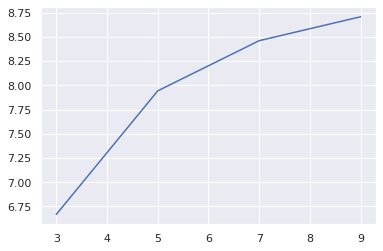

---Likelihoods---
Training: 17.493
Inlier: 17.503
Outlier: 14.708
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 7.859798 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
6.110995 (0.324712) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
7.076437 (0.282703) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
7.568717 (0.255098) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
7.859798 (0.363008) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_compo

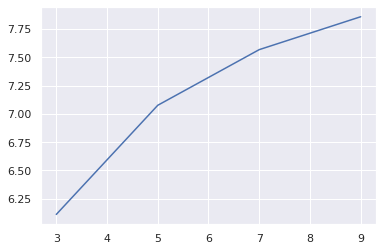

---Likelihoods---
Training: 19.931
Inlier: 19.844
Outlier: 17.459
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 15.770133 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
---------------------------------------------------------------------------
14.027685 (0.310387) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
14.242546 (0.562737) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
15.770133 (0.520242) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
15.765637 (0.504083) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_

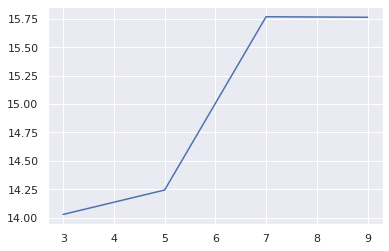

---Likelihoods---
Training: 29.141
Inlier: 29.088
Outlier: 24.575
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.632417 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
-1.500834 (0.196972) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
-0.831540 (0.279161) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
-0.239917 (0.429187) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
0.632417 (0.423909) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_co

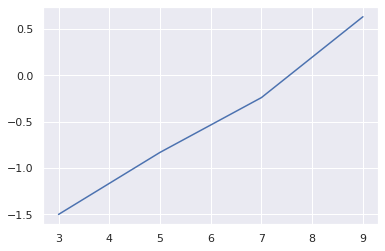

---Likelihoods---
Training: 12.568
Inlier: 12.301
Outlier: 9.409
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 15.089355 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
13.871928 (0.117890) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
14.301686 (0.214982) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
14.813748 (0.240419) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
15.089355 (0.261850) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_c

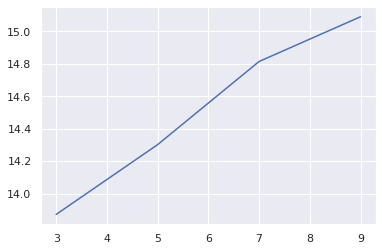

---Likelihoods---
Training: 22.229
Inlier: 21.980
Outlier: 19.153
========================= Training KD Tree =========================


In [35]:
all_metrics = []
for i in range(5):
    msma_results = get_msma_results(workdir, seed=i)
    all_metrics.append(msma_results)

In [36]:
gmm_metrics  = pd.concat(m["GMM"]["metrics"].reset_index(drop=True) for m in all_metrics
                        ).reset_index(drop=True)
gmm_metrics['seed'] = np.arange(5)
gmm_metrics['model'] = "MSMA-GMM"
gmm_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,65.759693,41.792898,90.273673,90.273673,65.743981,52.898518,60.555889,2.000000
std,3.587691,2.119297,2.486554,2.486554,3.589314,3.520741,3.443344,1.581139
min,62.393062,38.706041,86.480569,86.480569,62.376734,49.384090,57.249761,0.000000
25%,62.670089,40.699405,89.600438,89.600438,62.648014,49.887014,57.565563,1.000000
50%,64.609734,42.221880,90.394089,90.394089,64.598361,52.638712,59.812239,2.000000
75%,69.140455,43.566468,91.981390,91.981390,69.130252,54.698990,63.022526,3.000000
max,69.985127,43.770696,92.911877,92.911877,69.966546,57.883787,65.129358,4.000000


In [37]:
kd_metrics  = pd.concat(m["KD"]["metrics"].reset_index(drop=True) for m in all_metrics
                       ).reset_index(drop=True)
kd_metrics['seed'] = np.arange(5)
kd_metrics['model'] = "MSMA-KD"
kd_metrics

kd_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,66.769161,41.099548,90.908593,90.908593,66.768184,55.057689,61.902441,2.000000
std,3.183717,1.045417,0.862916,0.862916,3.187211,0.878703,1.853046,1.581139
min,62.897537,39.323515,89.381500,89.381500,62.891506,53.928077,59.837946,0.000000
25%,65.025613,41.105467,91.105638,91.105638,65.020283,54.586727,60.959618,1.000000
50%,66.570080,41.367508,91.242474,91.242474,66.571822,55.016844,61.601159,2.000000
75%,68.007097,41.757834,91.406678,91.406678,68.009938,55.530649,62.327946,3.000000
max,71.345477,41.943418,91.406678,91.406678,71.347371,56.226145,64.785536,4.000000


In [38]:
df_metrics = pd.concat([gmm_metrics, kd_metrics, baseline_metrics])
df_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                        \
           count       mean       std        min        25%        50%   
model                                                                    
DAGMM        5.0  53.204874  8.778400  37.525692  56.565747  56.731089   
DSVDD        5.0  58.204577  8.227783  46.896705  53.242511  59.460638   
ECOD         5.0  60.362771  0.496423  59.565040  60.313886  60.376742   
IForest      5.0  57.930607  1.727804  55.871075  57.100715  57.283619   
MSMA-GMM     5.0  60.555889  3.443344  57.249761  57.565563  59.812239   
MSMA-KD      5.0  61.902441  1.853046  59.837946  60.959618  61.601159   

                                  ap                                  \
                75%        max count       mean       std        min   
model                                                                  
DAGMM     57.490548  57.711294   5.0  57.621299  3.358685  51.673451   
DSVDD     64.295594  67.127437   5.0  67.178949  6.937240  57.226725   
ECOD      60.770831  60.787355   5.0  66.517978  0.571877  65.742967   
IForest   59.287033  60.110596   5.0  63.237336  1.736627  60.830338   
MSMA-GMM  63.022526  65.129358   5.0  65.759693  3.587691  62.393062   
MSMA-KD   62.327946  64.785536   5.0  66.769161  3.183717  62.897537   

                                                      
                25%        50%        75%        max  
model                                                 
DAGMM     58.430389  58.897208  59.515240  59.590205  
DSVDD     64.076847  67.449785  72.558461  74.582929  
ECOD      66.257708  66.563380  66.741076  67.284760  
IForest   62.653133  62.867655  64.649331  65.186225  
MSMA-GMM  62.670089  64.609734  69.140455  69.985127  
MSMA-KD   65.025613  66.570080  68.007097  71.345477

In [39]:
# df_metrics.to_csv(f"results/{config.data.dataset}_final_metrics.csv")

In [40]:
num_anos = len(all_metrics[0]["GMM"]["ood_scores"].ravel())
num_inliers = len(all_metrics[0]["GMM"]["test_scores"].ravel())
ano_ratio = num_anos / (num_anos+num_inliers)
print(f"Anomaly ratio for test set of {config.data.dataset}: {num_anos}/{num_inliers+num_anos} = {ano_ratio:.2f}")

Anomaly ratio for test set of bank: 4640/8294 = 0.56


In [41]:
df_stats = df_metrics.groupby('model').describe()

for metric in ["ap", "roc_auc"]:
    latex_str = [metric]
    latex_str.append(f"{ano_ratio:.2f}")
    df = df_stats.loc[["IForest","ECOD","DAGMM","DSVDD","MSMA-GMM"], metric]
    best =  df["mean"].max()
    for m in df[["mean", "std"]].values:
        _str = f"{m[0]:.2f} $\pm$~{m[1]:.2f}" 
        if np.isclose(m[0], best):
            _str = "\B "+_str
        latex_str.append(_str)
    latex_str = " & ".join(latex_str)
    print(latex_str)

ap & 0.56 & 63.24 $\pm$~1.74 & 66.52 $\pm$~0.57 & 57.62 $\pm$~3.36 & \B 67.18 $\pm$~6.94 & 65.76 $\pm$~3.59
roc_auc & 0.56 & 57.93 $\pm$~1.73 & 60.36 $\pm$~0.50 & 53.20 $\pm$~8.78 & 58.20 $\pm$~8.23 & \B 60.56 $\pm$~3.44


In [14]:
df_melt = df_metrics.drop(columns="seed").melt(id_vars="model", var_name="metric")
df_melt

,model,metric,value
0,MSMA-GMM,ap,69.140455
1,MSMA-GMM,ap,62.670089
2,MSMA-GMM,ap,64.613068
3,MSMA-GMM,ap,62.161276
4,MSMA-GMM,ap,69.291997
...,...,...,...
205,DSVDD,roc_auc,53.242511
206,DSVDD,roc_auc,46.896705
207,DSVDD,roc_auc,67.127437
208,DSVDD,roc_auc,59.460638


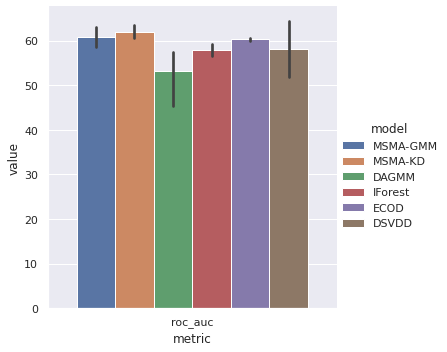

In [15]:
sns.catplot(data=df_melt.query("metric=='roc_auc'"), x="metric", y="value", hue="model", kind="bar")

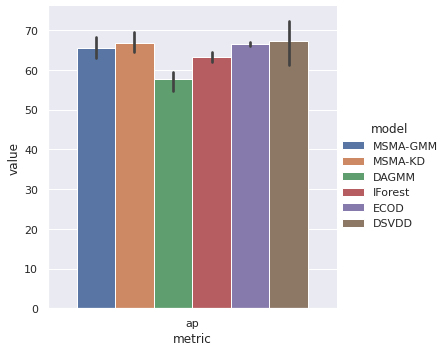

In [16]:
sns.catplot(data=df_melt.query("metric=='ap'"), x="metric", y="value", hue="model", kind="bar")